<a href="https://colab.research.google.com/github/muffafa/advent-of-haystack-2024-2025-solutions/blob/main/%5BSolution%5DAdvent_of_Haystack_EvaluationHarness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advent of Haystack: Day 10
_Make a copy of this Colab to start!_


In this challenge, we will evaluate our RAG pipeline using [EvaluationHarness](https://docs.haystack.deepset.ai/reference/experimental-evaluation-harness-api), an evaluation orchestrator that streamlines the assessment of pipeline performance and making the evaluation process simpler and more efficient.

🧪 `EvaluationHarness` is an experimental feature that will be merged into the main repository with Haystack 2.9.0. Find more info in this [GitHub discussion](https://github.com/deepset-ai/haystack-experimental/discussions/74)


## Installation

Start by installing `haystack-ai` and `datasets` packages:

In [ ]:
!pip install haystack-ai datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 391.4/391.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.8/109.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 req

## Enter OpenAI and HF API Keys

In this challenge, you will use [meta-llama/Llama-3.2-1B-Instruct](https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct) and [meta-llama/Llama-3.2-3B-Instruct](https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct) which are gated and requires extra steps to access through [Hugging Face Inference API](https://huggingface.co/docs/api-inference/en/index).


To access these models:
1. You need a [Hugging Face](https://huggingface.co/) account
2. You have to accept conditions in their model pages. You will get access in short time
3. Copy your HF token (https://huggingface.co/settings/tokens) and paste it below

The model page should have "**You have been granted access to this model**" text to indicate that you can use these models

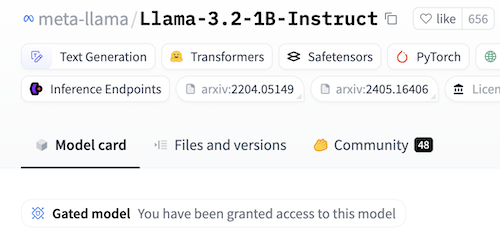

**NOTE:** To be able to use LLM-based evaluators, such as [FaithfulnessEvaluator](https://docs.haystack.deepset.ai/docs/faithfulnessevaluator), [ContextRelevanceEvaluator](https://docs.haystack.deepset.ai/docs/contextrelevanceevaluator), you need an `OPENAI_API_KEY`.

In [ ]:
import os
from getpass import getpass

os.environ["HF_API_TOKEN"] = getpass("Your Hugging Face token")
os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

Your Hugging Face token··········
Enter OpenAI API key:··········


## Prepare the Dataset

Download the [HotpotQA dataset](https://huggingface.co/datasets/hotpotqa/hotpot_qa) from Hugging Face:

In [ ]:
from datasets import load_dataset

data = load_dataset('hotpotqa/hotpot_qa', 'distractor', split='train[:50]', trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.19k [00:00<?, ?B/s]

hotpot_qa.py:   0%|          | 0.00/6.42k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/90447 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7405 [00:00<?, ? examples/s]

Check one of the entries to understand the data structure. In Hotpot QA, each entry includes a question, a ground-truth answer, context sentences and titles.

In [ ]:
data[4]

{'id': '5a84dd955542997b5ce3ff79',
 'question': 'Cadmium Chloride is slightly soluble in this chemical, it is also called what?',
 'answer': 'alcohol',
 'type': 'bridge',
 'level': 'medium',
 'supporting_facts': {'title': ['Cadmium chloride', 'Ethanol'],
  'sent_id': [1, 0]},
 'context': {'title': ['Cadmium chloride',
   'Water blue',
   'Diflucortolone valerate',
   'Heptanoic acid',
   'Magnesium chloride',
   'Ethanol',
   'Tributyltin oxide',
   'Benzamide',
   'Gold(III) chloride',
   'Chloride'],
  'sentences': [['Cadmium chloride is a white crystalline compound of cadmium and chlorine, with the formula CdCl.',
    ' It is a hygroscopic solid that is highly soluble in water and slightly soluble in alcohol.',
    ' Although it is considered to be ionic, it has considerable covalent character to its bonding.',
    ' The crystal structure of cadmium chloride (described below), composed of two-dimensional layers of ions, is a reference for describing other crystal structures.',
    '

Convert the datapoints into Haystack Documents to use in indexing, querying and evaluation. Each sentence will become a Haystack Document and store some information as metadata such as "rank" and "ground_truth_answer".

In [ ]:
from haystack.dataclasses.document import Document

def convert_hotpot_to_docs(data):
    question = []
    true_answer = []
    doc_chunks = []

    for item in data:

        question.append(item['question'])
        true_answer.append(item['answer'])

        # Documents
        assert len(item['context']["title"]) == len(item['context']["sentences"])
        context_dict = {item['context']["title"][i]: item['context']["sentences"][i] for i in range(len(item['context']["title"]))}

        # Add default rank (irrelevant docs will have the rank of 1000)
        for k, v in context_dict.items():
            context_dict[k] = [(vv, 1000, item["id"], item["question"], item["answer"]) for vv in v if vv.strip()] # remove empty contents

        # Add True rank (irrelevant docs will have the the true rank)
        assert len(item['supporting_facts']["title"]) == len(item['supporting_facts']["sent_id"])

        for i in range(len(item['supporting_facts']["title"])):

            k = item['supporting_facts']["title"][i] # Key
            v_pos = item['supporting_facts']["sent_id"][1] # Value
            rank = i

            if v_pos < len(context_dict[k]):
                context_dict[k][v_pos] = (context_dict[k][v_pos][0], rank, context_dict[k][v_pos][2], context_dict[k][v_pos][3], context_dict[k][v_pos][4])

        nested_list = [v for k, v in context_dict.items()]
        chunks = [x for xs in nested_list for x in xs]

        # Sort by rank (for MRR)
        sorted_chunks = sorted(chunks, key=lambda tup: tup[1])

        # Create Haystack Documents
        doc_chunks.append([Document(content=tup[0], meta={"rank":tup[1], "data_id":tup[2],  "question": tup[3], "ground_truth_answer": tup[4]}) for tup in sorted_chunks])

    return question, true_answer, doc_chunks

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
questions, ground_truth_answers, doc_chunks = convert_hotpot_to_docs(data)

In [ ]:
documents = [doc for chunk in doc_chunks for doc in chunk]

A relevant document example after processing:

```python
Document(
  id=414..ba,
  content: "Arthur's Magazine (1844–1846) was an American literary periodical published in Philadelphia in the 1...",
  meta: {'rank': 0, 'data_id': '5a87ab905542996e4f3088c1', 'question': "Which magazine was started first Arthur's Magazine or First for Women?", 'ground_truth_answer': "Arthur's Magazine"}
)
```

In [ ]:
ground_truth_answers

["Arthur's Magazine",
 'Delhi',
 'President Richard Nixon',
 'American',
 'alcohol',
 'Jonathan Stark',
 'Crambidae',
 'Badr Hari',
 '2006',
 '6.213 km long']

In [ ]:
questions

["Which magazine was started first Arthur's Magazine or First for Women?",
 'The Oberoi family is part of a hotel company that has a head office in what city?',
 'Musician and satirist Allie Goertz wrote a song about the "The Simpsons" character Milhouse, who Matt Groening named after who?',
 " What nationality was James Henry Miller's wife?",
 'Cadmium Chloride is slightly soluble in this chemical, it is also called what?',
 'Which tennis player won more Grand Slam titles, Henri Leconte or Jonathan Stark?',
 "Which genus of moth in the world's seventh-largest country contains only one species?",
 'Who was once considered the best kick boxer in the world, however he has been involved in a number of controversies relating to his "unsportsmanlike conducts" in the sport and crimes of violence outside of the ring.',
 'The Dutch-Belgian television series that "House of Anubis" was based on first aired in what year?',
 'What is the length of the track where the 2013 Liqui Moly Bathurst 12 Ho

### Create a ground truth dataset

Then, trim the irrelevant documents for the `ground_truth_documents` dataset

In [ ]:
ground_truth_documents = []

for chunk in doc_chunks:
  new_list = []
  for doc in chunk:
    if doc.meta["rank"] < 1000: # if a document is relevant
      new_list.append(doc)
  ground_truth_documents.append(new_list)

## Indexing Documents

Create a pipeline and index documents to [`InMemoryDocumentStore`](https://docs.haystack.deepset.ai/docs/inmemorydocumentstore). For document embeddings, use the[`BAAI/bge-m3`](https://huggingface.co/BAAI/bge-m3) model through [HuggingFaceAPIDocumentEmbedder](https://docs.haystack.deepset.ai/docs/huggingfaceapidocumentembedder).

⏳ This step might take around 3 minutes

In [ ]:
from haystack import Pipeline
from haystack.components.embedders import HuggingFaceAPIDocumentEmbedder
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.document_stores.types import DuplicatePolicy

document_store = InMemoryDocumentStore()
document_embedder = HuggingFaceAPIDocumentEmbedder(api_type="serverless_inference_api",
                                              api_params={"model": "BAAI/bge-m3"})
document_writer = DocumentWriter(document_store=document_store, policy=DuplicatePolicy.SKIP)

indexing = Pipeline()
indexing.add_component(instance=document_embedder, name="document_embedder")
indexing.add_component(instance=document_writer, name="document_writer")

indexing.connect("document_embedder.documents", "document_writer.documents")

indexing.run({"document_embedder": {"documents": documents}})

Calculating embeddings: 100%|██████████| 65/65 [03:36<00:00,  3.33s/it]


{'document_writer': {'documents_written': 2064}}

## RAG Pipeline
Create a basic RAG pipeline using [meta-llama/Llama-3.2-1B-Instruct](https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct) through [HuggingFaceAPIGenerator](https://docs.haystack.deepset.ai/docs/huggingfaceapigenerator)


In [ ]:
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack.components.embedders import HuggingFaceAPITextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.generators import HuggingFaceAPIGenerator

generator = HuggingFaceAPIGenerator(
    api_type="serverless_inference_api",
    api_params={"model": "meta-llama/Llama-3.2-1B-Instruct"},
)

template = """
<|start_header_id|>assistant<|end_header_id|>
Answer the following question based on the given context information only.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

rag_pipeline = Pipeline()
rag_pipeline.add_component(
    "query_embedder",
    HuggingFaceAPITextEmbedder(api_type="serverless_inference_api",
                                              api_params={"model": "BAAI/bge-m3"}),
)
rag_pipeline.add_component("retriever", InMemoryEmbeddingRetriever(document_store, top_k=3))
rag_pipeline.add_component("prompt_builder", PromptBuilder(template=template))
rag_pipeline.add_component("generator", generator)

rag_pipeline.connect("query_embedder", "retriever.query_embedding")
rag_pipeline.connect("retriever", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "generator")

🚅 Components
  - query_embedder: HuggingFaceAPITextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - generator: HuggingFaceAPIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)

Test your pipeline before starting evaluation

In [ ]:
question = "Cadmium Chloride is slightly soluble in this chemical, it is also called what?"

rag_pipeline.run({
    "query_embedder": {"text": question},
    "prompt_builder": {"question": question}
})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/inference/_client.py:2245: FutureWarning: `stop_sequences` is a deprecated argument for `text_generation` task and will be removed in version '0.28.0'. Use `stop` instead.
  warnings.warn(


{'generator': {'replies': [' Organic solvent'],
  'meta': [{'model': 'meta-llama/Llama-3.2-1B-Instruct',
    'finish_reason': 'eos_token',
    'usage': {'completion_tokens': 3}}]}}

## Task: Evaluate the RAG Pipeline with EvaluationHarness

`EvaluationHarness` executes a pipeline with a given set of inputs and evaluates its outputs with an evaluation pipeline using Haystack's built-in [Evaluators](https://docs.haystack.deepset.ai/docs/evaluators). This means you don't need to create a separate evaluation pipeline.

[RAGEvaluationHarness](https://docs.haystack.deepset.ai/reference/experimental-evaluation-harness-api#ragevaluationharness) class, derived from `EvaluationHarness`, simplifies the evaluation process specifically for RAG pipelines. It comes with a predefined set of evaluation metrics, detailed in the [RAGEvaluationMetric](https://docs.haystack.deepset.ai/reference/experimental-evaluation-harness-api#ragevaluationmetric) enum, and basic RAG architecture examples, listed in the [DefaultRAGArchitecture](https://docs.haystack.deepset.ai/reference/experimental-evaluation-harness-api#defaultragarchitecture) enum.

Your task is to calculate Semantic Answer Similarity, Faithfulness, Context Relevance, Document Recall (Single hit) and Document MRR scores using `RAGEvaluationHarness`.

In [ ]:
from haystack_experimental.evaluation.harness.rag import (
    DefaultRAGArchitecture,
    RAGEvaluationHarness,
    RAGEvaluationMetric,
    RAGEvaluationInput
)

## COMPLETE HERE
# Use Semantic Answer Similarity, Faithfulness, Context Relevance, Document Recall (Single hit) and Document MRR
# HINT: You need questions, ground_truth_answers and ground_truth_document
pipeline_eval_harness = RAGEvaluationHarness(
    rag_pipeline = rag_pipeline,
    rag_components=DefaultRAGArchitecture.GENERATION_WITH_EMBEDDING_RETRIEVAL,
    metrics={
        RAGEvaluationMetric.SEMANTIC_ANSWER_SIMILARITY,
        RAGEvaluationMetric.FAITHFULNESS,
        RAGEvaluationMetric.CONTEXT_RELEVANCE,
        RAGEvaluationMetric.DOCUMENT_RECALL_SINGLE_HIT,
        RAGEvaluationMetric.DOCUMENT_MRR,
    }
)

eval_harness_input = RAGEvaluationInput(
    queries=questions,
    ground_truth_answers=ground_truth_answers,
    ground_truth_documents=ground_truth_documents,
    rag_pipeline_inputs={
        "prompt_builder": {"question": list(questions)},
    },
)

harness_eval_run = pipeline_eval_harness.run(inputs=eval_harness_input, run_name="rag_eval")


Executing RAG pipeline...


100%|██████████| 50/50 [00:57<00:00,  1.14s/it]

Executing evaluation pipeline...



/usr/local/lib/python3.10/dist-packages/transformers/models/auto/configuration_auto.py:1006: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/sentence_transformers/SentenceTransformer.py:195: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v4 of SentenceTransformers.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

100%|██████████| 50/50 [01:15<00:00,  1.50s/it]


### Create a Score Report

Score report calculates the aggregated score for each metric across all questions

In [ ]:
harness_eval_run.results.score_report()

,metrics,score
0,metric_faithfulness,0.596667
1,metric_sas,0.507267
2,metric_doc_recall_single,0.760000
3,metric_doc_mrr,0.636667
4,metric_context_relevance,0.880000


### Increase `top_k`

Override the `top_k` value of your retriever and compare the results to the original pipeline evaluation results. Don't forget to create the score report.

💡 Expect to see increase in "recall"

**HINT:** Use [RAGEvaluationOverrides](https://docs.haystack.deepset.ai/reference/experimental-evaluation-harness-api#ragevaluationoverrides) instead of building a new pipeline from scratch

In [ ]:
from haystack_experimental.evaluation.harness.rag import RAGEvaluationOverrides

overrides = RAGEvaluationOverrides(rag_pipeline={
    "retriever": {"top_k": 10},
})

harness_eval_run_topk = pipeline_eval_harness.run(inputs=eval_harness_input, run_name="topk_10", overrides=overrides)

Executing RAG pipeline...


  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/huggingface_hub/inference/_client.py:2245: FutureWarning: `stop_sequences` is a deprecated argument for `text_generation` task and will be removed in version '0.28.0'. Use `stop` instead.
  warnings.warn(
100%|██████████| 50/50 [00:16<00:00,  3.07it/s]


Executing evaluation pipeline...


100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


In [ ]:
harness_eval_run_topk.results.score_report()

,metrics,score
0,metric_faithfulness,0.683333
1,metric_sas,0.598425
2,metric_doc_recall_single,0.880000
3,metric_doc_mrr,0.654079
4,metric_context_relevance,0.940000


### Change the Generative Model

Override the RAG pipeline, use [meta-llama/Llama-3.2-3B-Instruct](https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct) as the generative model in the RAG pipeline and see if it improves SAS and faithfulness.

In [ ]:
from haystack_experimental.evaluation.harness.rag import RAGEvaluationOverrides

overrides = RAGEvaluationOverrides(rag_pipeline={
    "generator": {"api_params":{"model": "meta-llama/Llama-3.2-3B-Instruct"}},
})

harness_eval_run_3b = pipeline_eval_harness.run(inputs=eval_harness_input, run_name="llama_3.2_3b", overrides=overrides)

Executing RAG pipeline...


  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/huggingface_hub/inference/_client.py:2245: FutureWarning: `stop_sequences` is a deprecated argument for `text_generation` task and will be removed in version '0.28.0'. Use `stop` instead.
  warnings.warn(
100%|██████████| 50/50 [00:17<00:00,  2.92it/s]


Executing evaluation pipeline...


100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


In [ ]:
harness_eval_run_3b.results.score_report()

,metrics,score
0,metric_faithfulness,0.643333
1,metric_sas,0.602177
2,metric_doc_recall_single,0.760000
3,metric_doc_mrr,0.636667
4,metric_context_relevance,0.880000


## Bonus: Evaluate a Hybrid Retrieval Pipeline

Add [InMemoryBM25Retriever](https://docs.haystack.deepset.ai/docs/inmemorybm25retriever) and [DocumentJoiner](https://docs.haystack.deepset.ai/docs/documentjoiner) to create a hybrid retrieval pipeline.


In [ ]:
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack.components.embedders import HuggingFaceAPITextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever, InMemoryBM25Retriever
from haystack.components.generators import HuggingFaceAPIGenerator
from haystack.components.joiners import DocumentJoiner

generator = HuggingFaceAPIGenerator(
    api_type="serverless_inference_api",
    api_params={"model": "meta-llama/Llama-3.2-1B-Instruct"},
)

template = """
<|start_header_id|>assistant<|end_header_id|>
Answer the following question based on the given context information only.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

hybrid_pipeline = Pipeline()
hybrid_pipeline.add_component(
    "query_embedder",
    HuggingFaceAPITextEmbedder(api_type="serverless_inference_api",
                                              api_params={"model": "BAAI/bge-m3"}),
)
hybrid_pipeline.add_component("embedding_retriever", InMemoryEmbeddingRetriever(document_store, top_k=3))
hybrid_pipeline.add_component("bm25_retriever", InMemoryBM25Retriever(document_store, top_k=3))
hybrid_pipeline.add_component("joiner", DocumentJoiner())
hybrid_pipeline.add_component("prompt_builder", PromptBuilder(template=template))
hybrid_pipeline.add_component("generator", generator)

hybrid_pipeline.connect("query_embedder", "embedding_retriever.query_embedding")
hybrid_pipeline.connect("embedding_retriever", "joiner")
hybrid_pipeline.connect("bm25_retriever", "joiner")
hybrid_pipeline.connect("joiner", "prompt_builder.documents")
hybrid_pipeline.connect("prompt_builder", "generator")

🚅 Components
  - query_embedder: HuggingFaceAPITextEmbedder
  - embedding_retriever: InMemoryEmbeddingRetriever
  - bm25_retriever: InMemoryBM25Retriever
  - prompt_builder: PromptBuilder
  - generator: HuggingFaceAPIGenerator
  - joiner: DocumentJoiner
🛤️ Connections
  - query_embedder.embedding -> embedding_retriever.query_embedding (List[float])
  - embedding_retriever.documents -> joiner.documents (List[Document])
  - bm25_retriever.documents -> joiner.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)
  - joiner.documents -> prompt_builder.documents (List[Document])

Test the pipeline

In [ ]:
question = "Cadmium Chloride is slightly soluble in this chemical, it is also called what?"

hybrid_pipeline.run({
    "query_embedder": {"text": question},
    "bm25_retriever": {"query": question},
    "prompt_builder": {"question": question}
})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/inference/_client.py:2245: FutureWarning: `stop_sequences` is a deprecated argument for `text_generation` task and will be removed in version '0.28.0'. Use `stop` instead.
  warnings.warn(


{'generator': {'replies': [' Cadmium chloride is slightly soluble in water, but very soluble in ethanol and ether.'],
  'meta': [{'model': 'meta-llama/Llama-3.2-1B-Instruct',
    'finish_reason': 'eos_token',
    'usage': {'completion_tokens': 18}}]}}

### RAGEvaluationHarness for Custom Pipelines

For `RAGEvaluationHarness` to work correctly for this custom pipeline, you need to map components correctly using [RAGExpectedComponent](https://docs.haystack.deepset.ai/reference/experimental-evaluation-harness-api#ragexpectedcomponent) and [RAGExpectedComponentMetadata](https://docs.haystack.deepset.ai/reference/experimental-evaluation-harness-api#ragexpectedcomponentmetadata).

You can find more details in [Evaluating RAG Pipelines with EvaluationHarness](https://haystack.deepset.ai/cookbook/rag_eval_harness#bonus-evaluationharness-for-custom-rag-pipelines)

In [ ]:
from haystack_experimental.evaluation.harness.rag import (
    DefaultRAGArchitecture,
    RAGEvaluationHarness,
    RAGEvaluationMetric,
    RAGEvaluationInput,
    RAGExpectedComponent,
    RAGExpectedComponentMetadata
)

## COMPLETE HERE
# Use Semantic Answer Similarity, Faithfulness, Context Relevance, Document Recall (Single hit) and Document MRR
# HINT: You need questions, ground_truth_answers and ground_truth_document
hybrid_eval_harness = RAGEvaluationHarness(
    rag_pipeline = hybrid_pipeline,
    rag_components={
        RAGExpectedComponent.QUERY_PROCESSOR: RAGExpectedComponentMetadata(
            "query_embedder", input_mapping={"query": "text"}
        ),
        RAGExpectedComponent.DOCUMENT_RETRIEVER: RAGExpectedComponentMetadata(
            "joiner",
            output_mapping={"retrieved_documents": "documents"},
        ),
        RAGExpectedComponent.RESPONSE_GENERATOR: RAGExpectedComponentMetadata(
            "generator", output_mapping={"replies": "replies"}
        ),
    },
    metrics={
        RAGEvaluationMetric.SEMANTIC_ANSWER_SIMILARITY,
        RAGEvaluationMetric.FAITHFULNESS,
        RAGEvaluationMetric.CONTEXT_RELEVANCE,
        RAGEvaluationMetric.DOCUMENT_RECALL_SINGLE_HIT,
        RAGEvaluationMetric.DOCUMENT_MRR,
    }
)

eval_harness_input = RAGEvaluationInput(
    queries=questions,
    ground_truth_answers=ground_truth_answers,
    ground_truth_documents=ground_truth_documents,
    rag_pipeline_inputs={
        "prompt_builder": {"question": list(questions)},
        "bm25_retriever": {"query": list(questions)}
    },
)

harness_hybrid_eval_run = hybrid_eval_harness.run(inputs=eval_harness_input, run_name="rag_eval")


Executing RAG pipeline...


  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/huggingface_hub/inference/_client.py:2245: FutureWarning: `stop_sequences` is a deprecated argument for `text_generation` task and will be removed in version '0.28.0'. Use `stop` instead.
  warnings.warn(
100%|██████████| 50/50 [01:29<00:00,  1.80s/it]
/usr/local/lib/python3.10/dist-packages/transformers/models/auto/configuration_auto.py:1006: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sentence_transformers/SentenceTransformer.py:195: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v4 of SentenceTransformers.
  warnings.warn(


Executing evaluation pipeline...


100%|██████████| 50/50 [00:56<00:00,  1.13s/it]


In [ ]:
harness_hybrid_eval_run.results.score_report()

,metrics,score
0,metric_faithfulness,0.680833
1,metric_sas,0.533664
2,metric_doc_recall_single,0.840000
3,metric_doc_mrr,0.597667
4,metric_context_relevance,0.940000
